In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import layers
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.colors
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
tf.keras.backend.clear_session()  # For easy reset of notebook state.


In [2]:
#import logging, os
#logging.disable(logging.WARNING)
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
dataset_name = 'synthetic'
#dataset_name = 'MNIST'

In [4]:
def write_tsv(array, name):
    if len(array.shape) == 2:
        l, w = array.shape
    else:
        array = array.reshape(-1,1)
        l, w = array.shape
    
    with open(name,'w') as f:
        for i in range(l):
            for j in range(w):
                f.write(str(array[i,j]))
                if j != w-1:
                    f.write('\t')
            f.write('\n')
            
            

In [5]:
def log_normal(x, mu, log_var,axis=-1):
    var = tf.exp(log_var)
    return -0.5 * tf.reduce_mean(log_var, 1) - 0.5 * tf.reduce_mean(tf.divide(
                tf.square( x- mu), var), 1)

In [6]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, z_mean, z_log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

activation_func = None

class Q_z(layers.Layer):
    def __init__(self,
                intermediate_dim,
                latent_dim,
               name='qz',
               **kwargs):
        super(Q_z, self).__init__(name=name, **kwargs)
        self.k = k
        self.dense_proj = layers.Dense(intermediate_dim, activation=activation_func)
        self.dense_proj_2 = layers.Dense(intermediate_dim, activation=activation_func)
        self.dense_mean = layers.Dense(latent_dim,activation=None)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self,inputs):
        x = self.dense_proj(inputs)
        x = self.dense_proj_2(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling(z_mean, z_log_var)
        return z_mean,z_log_var, z

class Q_w(layers.Layer):
    def __init__(self,
                intermediate_dim,
                latent_dim,
               name='qw',
               **kwargs):
        super(Q_w, self).__init__(name=name, **kwargs)
        self.k = k
        self.dense_proj = layers.Dense(intermediate_dim, activation=activation_func)
        self.dense_proj_2 = layers.Dense(intermediate_dim, activation=activation_func)
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self,inputs):
        x = self.dense_proj(inputs)
        x = self.dense_proj_2(x)
        w_mean = self.dense_mean(x)
        w_log_var = self.dense_log_var(x)
        w = self.sampling(w_mean, w_log_var)
        return w_mean,w_log_var, w

    
class P_y_wz(layers.Layer):
    def __init__(self,
                k,
                intermediate_dim,
                name='pywz',
               **kwargs): 
        super(P_y_wz, self).__init__(name=name, **kwargs)
        self.k = k
        self.dense_proj = layers.Dense(intermediate_dim, activation=activation_func)
        self.dense_proj_2 = layers.Dense(intermediate_dim,activation=activation_func)
        self.dense_logit = layers.Dense(k)
    
    def call(self, w,z):
        w_z = tf.concat([w,z],1)
        x = self.dense_proj(w_z)
        x = self.dense_proj_2(x)
        logit = self.dense_logit(x)
        p_y_wz = tf.nn.softmax(logit)
        return p_y_wz

    
class P_z_wy(layers.Layer):
    def __init__(self,
                 k,
                intermediate_dim,
                 latent_dim,
                 name='pzwy',
               **kwargs):
        super(P_z_wy, self).__init__(name=name, **kwargs)
        self.k = k
        self.dense_proj = layers.Dense(intermediate_dim, activation=activation_func)
        self.dense_pre_z = layers.Dense(intermediate_dim, activation=activation_func)
        #self.dense_mean = layers.Dense(latent_dim, activation=None)#[layers.Dense(latent_dim, activation=None) for i in range(self.k)]
        #self.dense_log_var = layers.Dense(latent_dim, activation=None)#[layers.Dense(latent_dim, activation=None) for i in range(self.k)]
        self.dense_mean =[layers.Dense(latent_dim, activation=None) for i in range(self.k)]
        self.dense_log_var = [layers.Dense(latent_dim, activation=None) for i in range(self.k)]
        self.sampling = Sampling()

        
    def call(self,w):
        x = self.dense_proj(w)
        pre_z = self.dense_pre_z(x)
        z_log_var_list = [None] * k
        z_mean_list = [None] * k
        z_list = [None] * k
        for i in range(k):
            #onehot_y = tf.one_hot([i]*pre_z.shape[0],self.k)
            #w_y = tf.concat([pre_z,onehot_y],1)
            #z_mean_list[i] = self.dense_mean(w_y)
            #z_log_var_list[i] = self.dense_log_var(w_y)
            #z_list[i] = self.sampling(z_mean_list[i], z_log_var_list[i])
            z_mean_list[i] = self.dense_mean[i](pre_z)
            z_log_var_list[i] = self.dense_log_var[i](pre_z)
            z_list[i] = self.sampling(z_mean_list[i], z_log_var_list[i])
        return z_mean_list, z_log_var_list, z_list
    
    def get_sample(self,w,i):
        x = self.dense_proj(w)
        pre_z = self.dense_pre_z(x)
        #onehot_y = tf.one_hot([i]*pre_z.shape[0],self.k)
        #w_y = tf.concat([pre_z,onehot_y],1)
        z_mean = self.dense_mean[i](pre_z)
        z_log_var = self.dense_log_var[i](pre_z)
        return self.sampling(z_mean, z_log_var)
    
class P_x_z(layers.Layer):
    def __init__(self,
                intermediate_dim,
                 original_dim,
                 output_act,
                 name='pxz',
               **kwargs):
        super(P_x_z, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation=activation_func)
        self.dense_proj_2 = layers.Dense(intermediate_dim, activation=activation_func)
        self.recon = layers.Dense(original_dim, activation=output_act)
        
    def call(self,z):
            pre_x = self.dense_proj(z)
            pre_x = self.dense_proj_2(pre_x)
            return self.recon(pre_x)

In [7]:
class GMM_VAE(tf.keras.Model):
    def __init__(self,
                k,
               original_dim,
               intermediate_dim,
               z_dim, 
               latent_dim,
                output_act=None,
               name='vae',
            
               **kwargs):
        super(GMM_VAE, self).__init__(name=name, **kwargs)
        self.k = k
        self.original_dim = original_dim
        self.Q_z = Q_z(intermediate_dim,z_dim)
        self.Q_w = Q_w(intermediate_dim,latent_dim)
        self.P_y_wz = P_y_wz(k,intermediate_dim)
        self.P_z_wy = P_z_wy(k,intermediate_dim,z_dim)
        self.P_x_z = P_x_z(intermediate_dim,original_dim,output_act)
    
    def call(self, inputs,y_prior_threshold,recon_loss_alpha=1):
        w_x_mean,w_x_log_var, w_x =  self.Q_w(inputs)
        z_x_mean, z_x_log_var, z_x = self.Q_z(inputs)
        p_y_wz = self.P_y_wz(w_x,z_x)
        z_yw_mean_list, z_yw_log_var_list, z_yw_list = self.P_z_wy(w_x)
        recon_x = [None] * self.k
        recon_loss = 0 
        for i in range(self.k):
            recon_x[i] = self.P_x_z(z_yw_list[i])
            r_loss = tf.reduce_sum((recon_x[i]-inputs)**2,1) 
            recon_loss += r_loss * p_y_wz[:,i]
            

        logq = log_normal(z_x,z_x_mean,z_x_log_var)        


        cond_prior = 0
        for i in range(len(z_yw_mean_list)):
            logp_i =  log_normal(z_x,z_yw_mean_list[i],z_yw_log_var_list[i])
            cond_prior += tf.multiply(logp_i-logq, p_y_wz[:,i])
        
        y_prior =  -tf.math.log(1/self.k)+ tf.reduce_sum(tf.multiply(p_y_wz,tf.math.log(p_y_wz+1e-10)),axis=-1)
        KL_w =  0.5 * tf.reduce_sum( 1 + w_x_log_var - tf.exp(w_x_log_var) - tf.square(w_x_mean) , 1)
        
        y_prior_ = -tf.maximum(y_prior,y_prior_threshold)
        
        reg_term = KL_w + cond_prior + y_prior_
        return tf.reduce_mean(recon_loss*recon_loss_alpha-reg_term),tf.reduce_mean(recon_loss),tf.reduce_mean(y_prior),tf.reduce_mean(cond_prior), tf.reduce_mean(KL_w)
    
    def get_decoded(self, w,y):
        z = self.P_z_wy.get_sample(w,y)
        return self.P_x_z(z)
        
    def get_latent(self, inputs):
        _, _, z_x = self.Q_z(inputs)
        return z_x

    

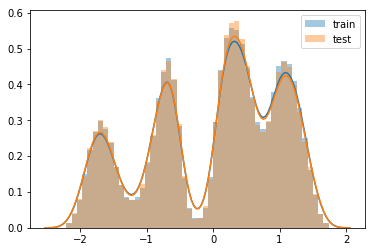

In [8]:
if dataset_name == 'MNIST':
    (x_train, _), _ = tf.keras.datasets.mnist.load_data()
    x_train = x_train.reshape(60000, 784).astype('float32') / 255
elif dataset_name == 'synthetic':
    all_data= np.load('traj.npy').astype(np.float32)
    all_data= (all_data - all_data.mean())/all_data.std()
    np.random.shuffle(all_data)
    train_size = 100000
    x_train = all_data[:train_size]
    x_test = all_data[train_size:train_size*2]
    gm = GaussianMixture(n_components=8)
    clusters = gm.fit_predict(x_train)
    sns.distplot(x_train,label='train')
    sns.distplot(x_test,label='test')
    plt.legend()
else:
    raise Exception('Unknown Dataset')

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)

In [10]:
if dataset_name == 'MNIST':
    original_dim=784
    k = 10
    z_dim = 128
    vae = GMM_VAE(k=k, original_dim=original_dim, z_dim=z_dim, intermediate_dim=z_dim, latent_dim=2,output_act="sigmoid")
    recon_loss_alpha =1
    input_size = 28
    epoch_number = 8
    y_prior_threshold =  - np.log(1/k) * 0.5
    v_max= 1
    v_min = 0
    cmap = 'bone'
else :
    original_dim=1
    k = 10
    z_dim = 16
    input_size = 1
    vae = GMM_VAE(k=k, original_dim=original_dim, z_dim=z_dim, intermediate_dim=z_dim, latent_dim=2,output_act=None) #, input_shape=(784,)
    recon_loss_alpha = 10
    input_size=1
    epoch_number = 4
    y_prior_threshold = - np.log(1/k) *0.9
    v_max= -2
    v_min = 2
    levels = [0, 1, 2, 3, 4, 5]
    colors = ['red', 'brown', 'yellow', 'green', 'blue']
    cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)


In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_metric = tf.keras.metrics.Mean()

In [12]:
# Iterate over epochs.
prior_losss_list = []
for epoch in range(epoch_number):
    print('Start of epoch %d' % (epoch,))
    for step, x_batch_train in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            loss,recon_loss,prior_loss,cond_prior,KL_w = vae(x_batch_train,recon_loss_alpha=recon_loss_alpha,y_prior_threshold=y_prior_threshold)
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        loss_metric(loss)
        prior_losss_list.append(prior_loss.numpy())
        if step % 100 == 0:
            print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()),
                  recon_loss.numpy(),prior_loss.numpy(),cond_prior.numpy(),KL_w.numpy())
            
    
            

Start of epoch 0
step 0: mean loss = 32.206543 2.956005 0.64758015 -0.3204324 -0.2535123
step 100: mean loss = 10.919218 0.217484 1.5211983 -0.42449754 -1.2126131
step 200: mean loss = 8.278903 0.13055323 1.652613 -0.2648162 -1.212853
step 300: mean loss = 7.101874 0.09143293 1.803627 -0.23632428 -1.3388495
step 400: mean loss = 6.451047 0.06766215 1.6947691 -0.1835154 -1.2788534
step 500: mean loss = 6.041258 0.07010627 1.7501714 -0.15458158 -1.3657146
step 600: mean loss = 5.757547 0.07131264 1.7163482 -0.15661532 -1.2963693
step 700: mean loss = 5.5486546 0.089623034 1.6814048 -0.15895075 -1.3002386
Start of epoch 1
step 0: mean loss = 5.410983 0.0680342 1.6163287 -0.117950596 -1.2316165
step 100: mean loss = 5.275331 0.08333148 1.6267685 -0.12555638 -1.1551571
step 200: mean loss = 5.155049 0.060632817 1.6681585 -0.13583839 -1.1105117
step 300: mean loss = 5.049465 0.083473034 1.691622 -0.1672532 -0.9041134
step 400: mean loss = 4.954942 0.07104731 1.7553331 -0.14369601 -0.94253194

KeyboardInterrupt: 

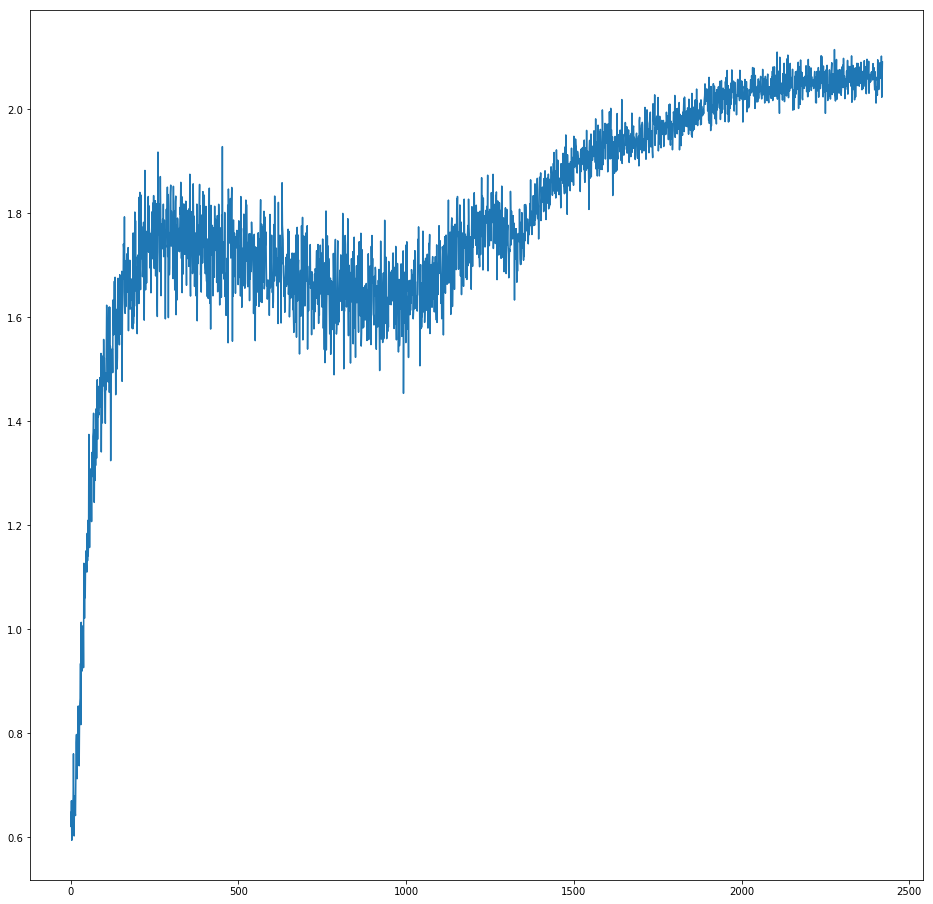

In [14]:
plt.figure(figsize=(16,16))
plt.plot(prior_losss_list)
plt.savefig('gmm_vae/y_prior' + dataset_name)

Cluster: 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



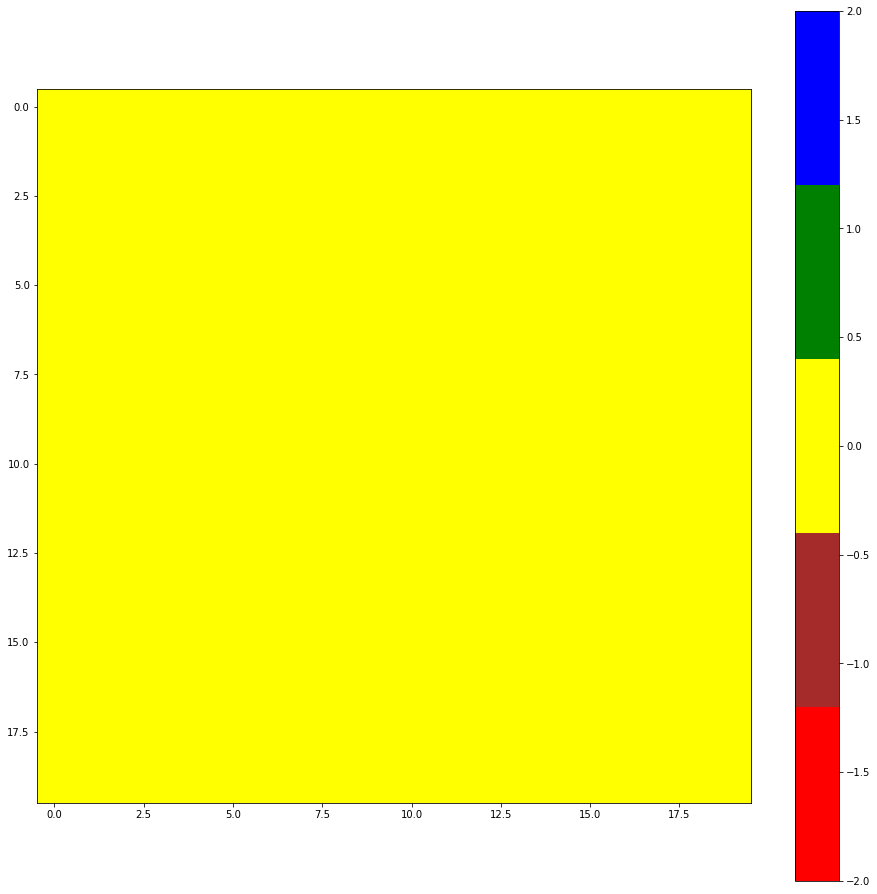

Cluster: 1


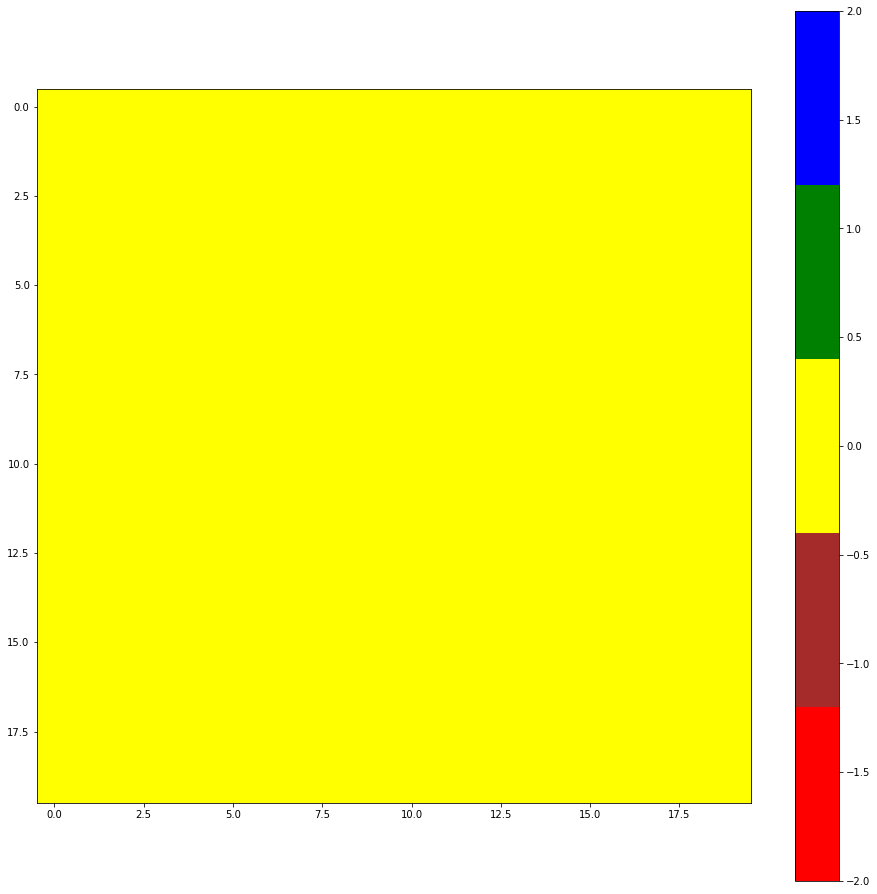

Cluster: 2


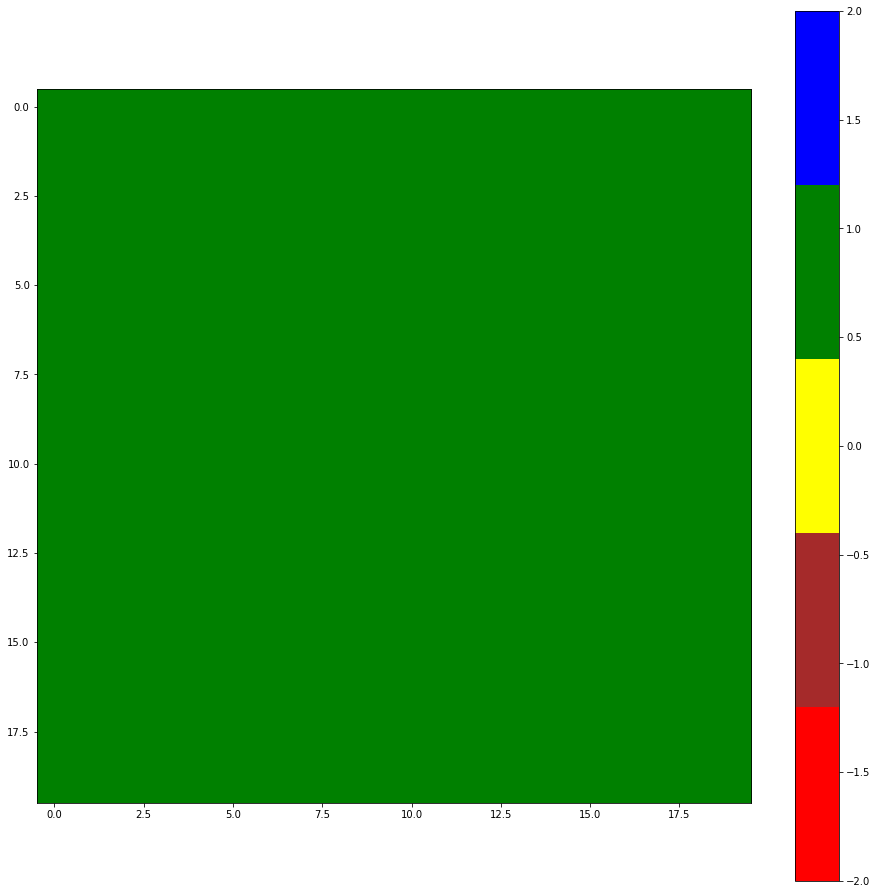

Cluster: 3


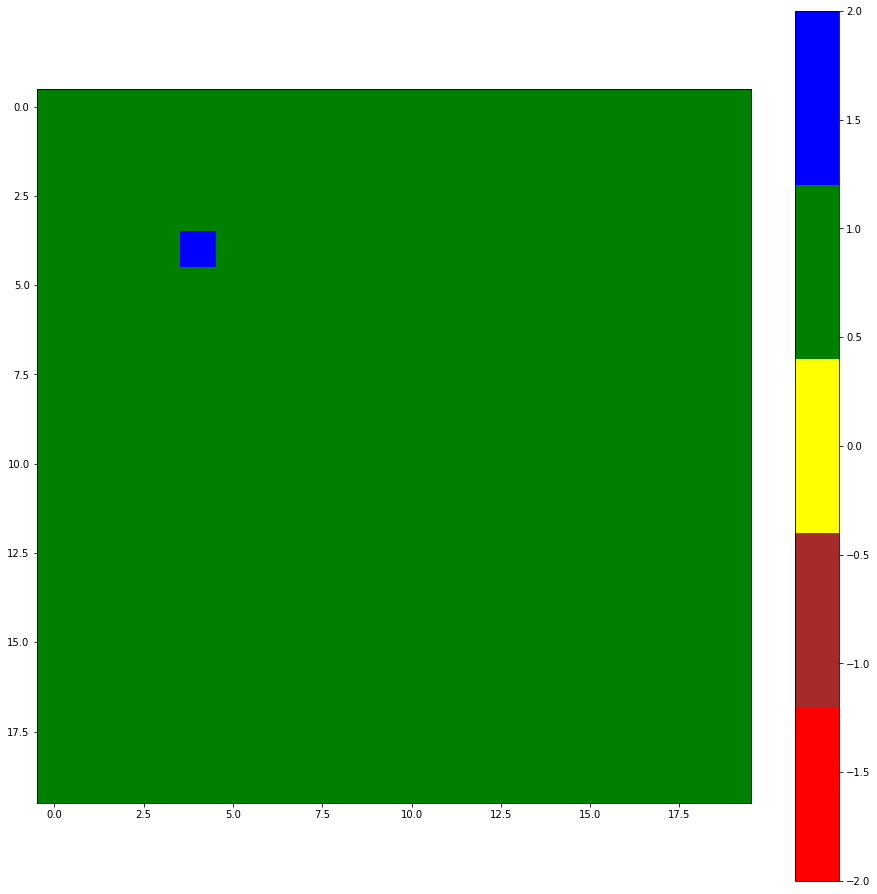

Cluster: 4


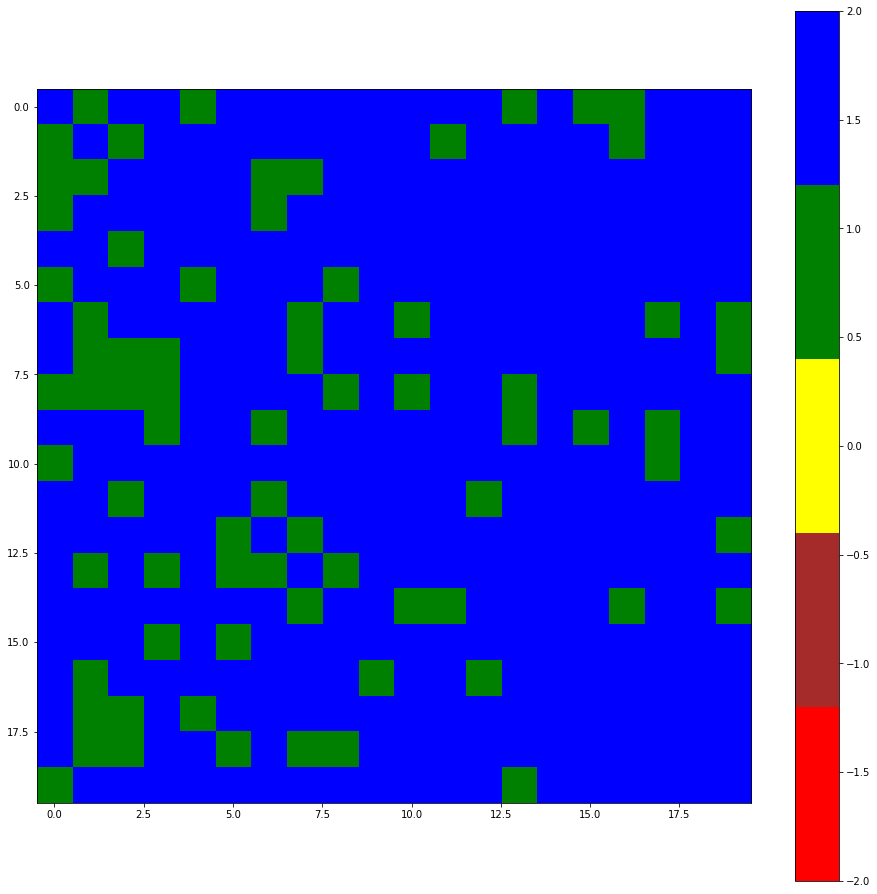

Cluster: 5


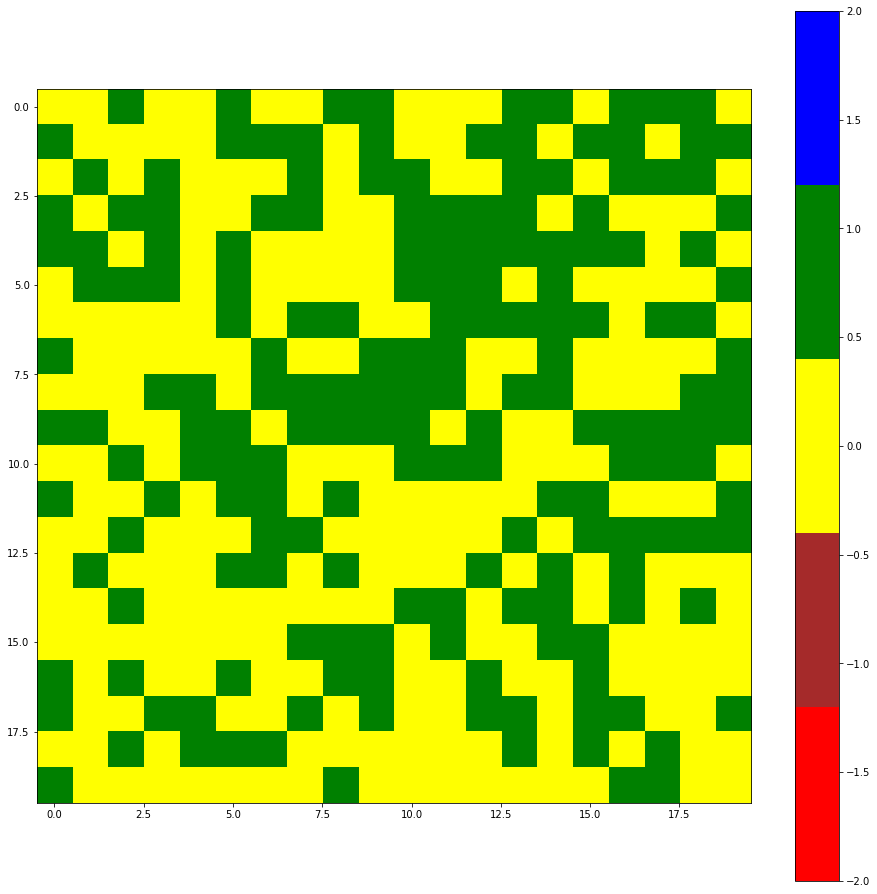

Cluster: 6


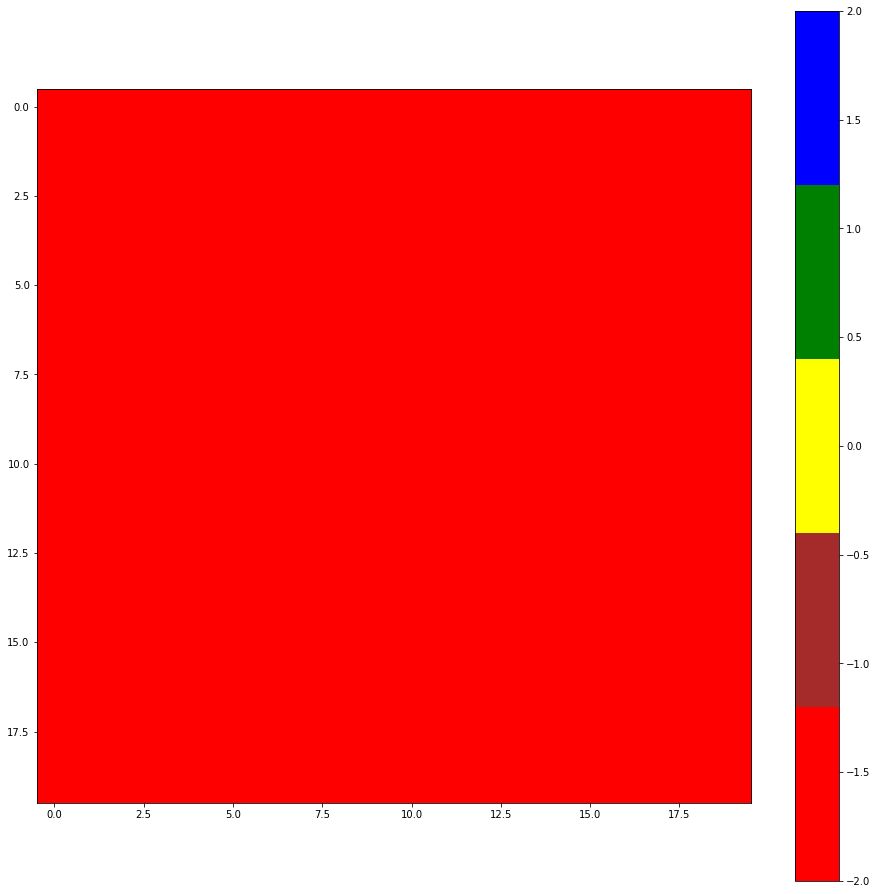

Cluster: 7


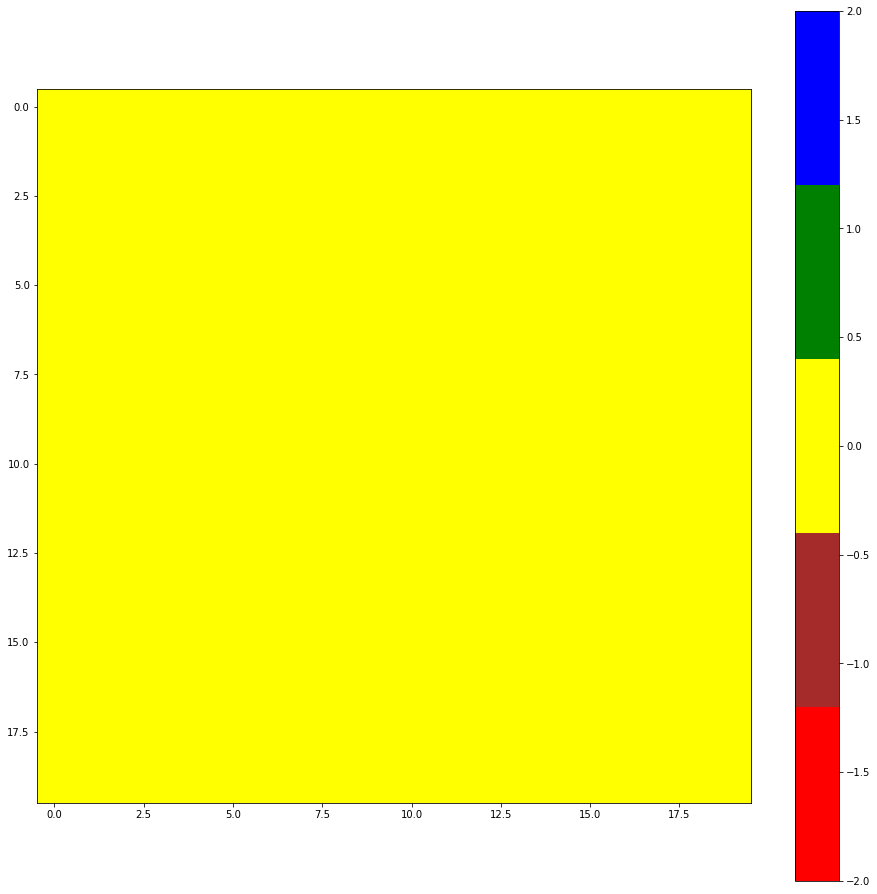

Cluster: 8


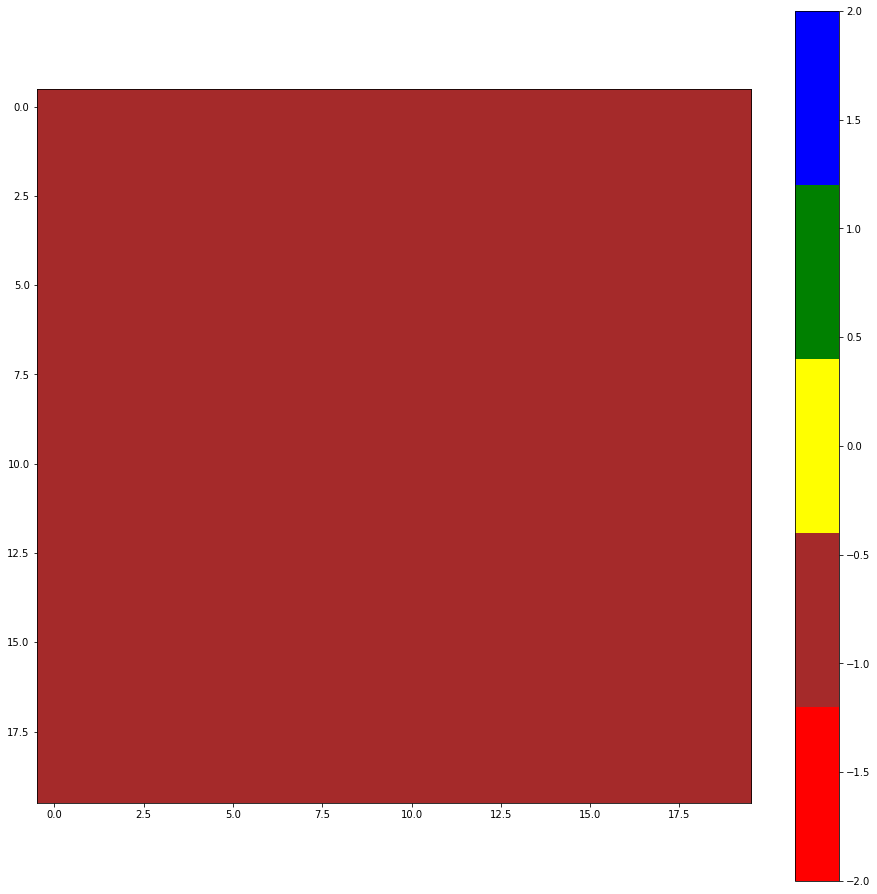

Cluster: 9


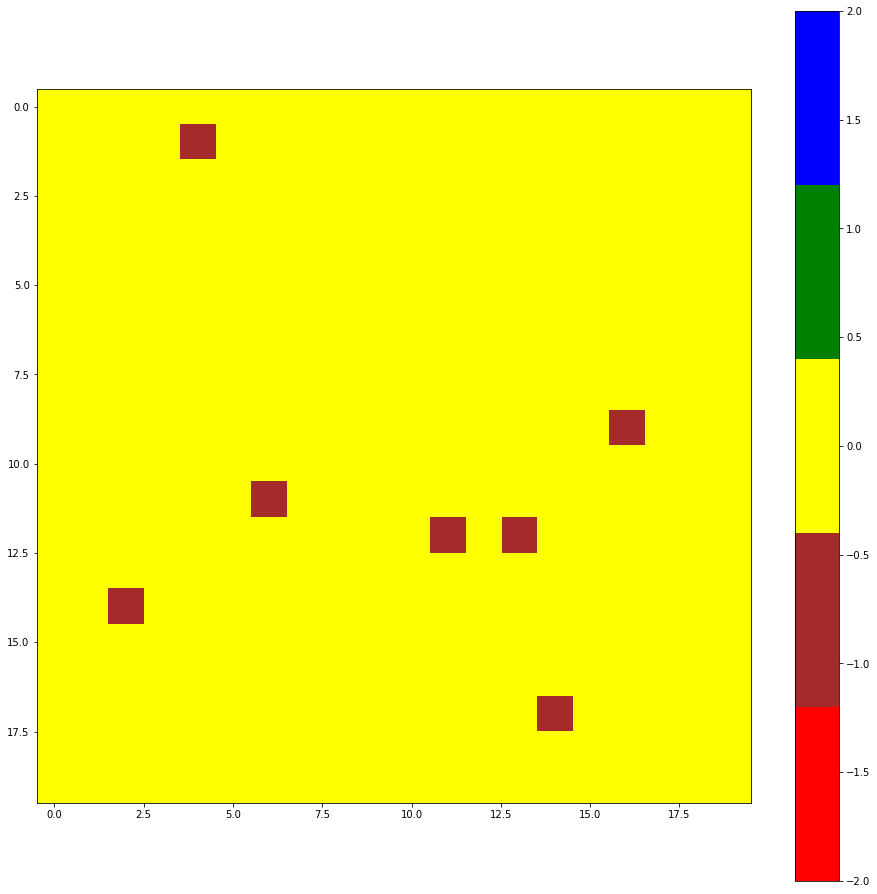

In [15]:
for cluster in range(k):
    from scipy.stats import norm
    batch_size = 1
    n = 20
    # figure with 20x20 digits
    input_size = input_size
    figure = np.zeros((input_size * n, input_size * n))
    print('Cluster:',cluster)
    # Construct grid of latent variable values
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    # decode for each square in the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
            x_decoded = vae.get_decoded(z_sample,cluster)
            recon_sample = x_decoded[0].numpy().reshape(input_size, input_size)
            figure[i * input_size: (i + 1) * input_size,
                   j * input_size: (j + 1) * input_size] = recon_sample

    plt.figure(figsize=(16, 16))
    plt.imshow(figure,cmap=cmap,vmax=v_min,vmin=v_max)
    plt.colorbar()
    plt.savefig('gmm_vae/gmm_vae_decoded_latent_cluster='+ str(cluster) + '_' + dataset_name)
    plt.show()  

In [16]:
if dataset_name == "MNIST":
    (_, _), (x_test,label_test) = tf.keras.datasets.mnist.load_data()
    x_test = x_test.reshape(10000, 784).astype('float32') / 255
    z = vae.get_latent(x_test)
    write_tsv(z[:1000].numpy().astype(np.float16),'mnist_z.tsv')
    write_tsv(label_test[:1000],'mnist_label.tsv')
else:
    label_test = gm.predict(x_test)
    z = vae.get_latent(x_test)
    write_tsv(z[:10000].numpy().astype(np.float32),'synthetic_z.tsv')
    write_tsv(label_test[:10000],'synthetic_label.tsv')

In [13]:
plt.figure(figsize=(16,16))
pca = PCA(n_components=2)
z_tranform = pca.fit_transform(z)
plt.scatter(z_tranform[:,0],z_tranform[:,1],c=label_test)
plt.savefig('gmm_vae/gmm_vae_encoded_latent_' + dataset_name)

NameError: name 'z' is not defined

<Figure size 1152x1152 with 0 Axes>